<a href="https://colab.research.google.com/github/rallm/IUST-DL-Fall2025/blob/main/HW4/practical/dl_hw4_p7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import gdown
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

# Download Model Weights
# Dictionary containing file IDs for the three models
model_files = {
    'cifar100_Model_A.pth': '1pUOFq2o-E6cqwIbM8d5Gtd586QT2musx',
    'cifar100_Model_B.pth': '1SZMMCNrpyoNwPOn90TfK1I1ht6wKo53K',
    'cifar100_Model_C.pth': '1BDcFCzIk2YzuboRG_HSd7GIuAyaMKrox'
}

print("Downloading model checkpoints...")
for filename, file_id in model_files.items():
    if not os.path.exists(filename):
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, filename, quiet=False)
    else:
        print(f"{filename} already exists.")

Running on: cuda


Downloading...
From: https://drive.google.com/uc?id=1pUOFq2o-E6cqwIbM8d5Gtd586QT2musx
To: /content/cifar100_Model_A.pth
100%|██████████| 1.13M/1.13M [00:00<00:00, 68.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1SZMMCNrpyoNwPOn90TfK1I1ht6wKo53K
From (redirected): https://drive.google.com/uc?id=1SZMMCNrpyoNwPOn90TfK1I1ht6wKo53K&confirm=t&uuid=274d85a6-638b-4d54-99e1-acffcd0e7d1c
To: /content/cifar100_Model_B.pth
100%|██████████| 57.0M/57.0M [00:01<00:00, 55.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1BDcFCzIk2YzuboRG_HSd7GIuAyaMKrox
From (redirected): https://drive.google.com/uc?id=1BDcFCzIk2YzuboRG_HSd7GIuAyaMKrox&confirm=t&uuid=46ae7036-2213-414f-aeca-ab0963a1f69c
To: /content/cifar100_Model_C.pth
100%|██████████| 36.2M/36.2M [00:00<00:00, 38.9MB/s]


In [3]:
# Import architecture definitions
try:
    from structure import UnderfittingModel, OverfittingModel, BestModel
except ImportError:
    print("Error: structure.py not found. Please upload it.")

# Because the models were likely saved in a script where these classes were in main,
# we map them to __main__ so pickle can find them.
import sys
import structure
sys.modules['__main__'].UnderfittingModel = structure.UnderfittingModel
sys.modules['__main__'].OverfittingModel = structure.OverfittingModel
sys.modules['__main__'].BestModel = structure.BestModel

# CIFAR-100 Data Preparation
mean_stats = (0.5071, 0.4867, 0.4408)
std_stats = (0.2675, 0.2565, 0.2761)

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_stats, std_stats)
])

test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

# Corrected Helper Function
def load_pretrained_model(model_class, weight_path):
    # Fix 1: weights_only=False allows loading custom classes (Safe if you trust the file)
    checkpoint = torch.load(weight_path, map_location=device, weights_only=False)

    # Fix 2: Handle both full model save and state_dict save
    if isinstance(checkpoint, nn.Module):
        # If the file contains the full model object
        model = checkpoint
    else:
        # If the file contains just the weights (dictionary)
        model = model_class()
        model.load_state_dict(checkpoint)

    model.to(device)
    model.eval()
    return model

# Initialize and load
print("Loading models into memory...")
net_a = load_pretrained_model(UnderfittingModel, 'cifar100_Model_A.pth')
net_b = load_pretrained_model(OverfittingModel, 'cifar100_Model_B.pth')
net_c = load_pretrained_model(BestModel, 'cifar100_Model_C.pth')
print("Models A, B, and C loaded successfully.")

Loading models into memory...
Models A, B, and C loaded successfully.


In [4]:
def get_last_conv_layer(model):
    """
    Automatically find the last convolutional layer for Grad-CAM.
    """
    layers = list(model.modules())
    # Iterate backwards to find the last Conv2d layer
    for layer in reversed(layers):
        if isinstance(layer, nn.Conv2d):
            return layer
    return None

def compute_gradcam(model, img_tensor, target_class=None):
    """
    Computes the Grad-CAM map for a given image and model.
    """
    # Placeholder for gradients and activations
    gradients = []
    activations = []

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def save_activation(module, input, output):
        activations.append(output)

    # Attach hooks to the target layer
    target_layer = get_last_conv_layer(model)
    handle_f = target_layer.register_forward_hook(save_activation)
    handle_b = target_layer.register_full_backward_hook(save_gradient)

    # Forward pass
    model.zero_grad()
    output = model(img_tensor)

    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Backward pass to get gradients
    # Create a one-hot vector for the target class
    target_vector = torch.zeros_like(output)
    target_vector[0][target_class] = 1
    output.backward(gradient=target_vector, retain_graph=True)

    # Process maps
    # Gradients: (Batch, Channel, H, W) -> Take first item in batch
    grads = gradients[0].cpu().data.numpy()[0]
    # Activations: (Batch, Channel, H, W) -> Take first item in batch
    fmaps = activations[0].cpu().data.numpy()[0]

    # Global Average Pooling on gradients (Weights)
    weights = np.mean(grads, axis=(1, 2))

    # Calculate weighted combination of feature maps
    cam = np.zeros(fmaps.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmaps[i]

    # Apply ReLU (we only care about positive influence)
    cam = np.maximum(cam, 0)

    # Resize heatmap to match input image dimensions
    img_h, img_w = img_tensor.shape[2], img_tensor.shape[3]
    cam = cv2.resize(cam, (img_w, img_h))

    # Normalize between 0 and 1
    if np.max(cam) != 0:
        cam = cam / np.max(cam)

    # Cleanup hooks
    handle_f.remove()
    handle_b.remove()

    return cam, target_class

def compute_occlusion_sensitivity(model, img_tensor, target_class, patch_size=8, stride=2):
    """
    Computes Occlusion Sensitivity Map (Zeiler & Fergus technique).
    Slides a grey patch over the image and measures the drop in probability.
    """
    width, height = img_tensor.shape[2], img_tensor.shape[3]
    heatmap = np.zeros((width, height))

    model.eval()
    with torch.no_grad():
        # Get baseline probability for the correct class
        logits = model(img_tensor)
        base_prob = torch.softmax(logits, dim=1)[0, target_class].item()

        # Sliding window loop
        for h in range(0, height - patch_size + 1, stride):
            for w in range(0, width - patch_size + 1, stride):
                # Mask the image region with grey (0 in normalized space roughly)
                occluded_img = img_tensor.clone()
                occluded_img[0, :, h:h+patch_size, w:w+patch_size] = 0

                # Check probability again
                output = model(occluded_img)
                prob = torch.softmax(output, dim=1)[0, target_class].item()

                # Record the drop in confidence
                # High drop means the region was important
                heatmap[h:h+patch_size, w:w+patch_size] = base_prob - prob

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0) # Keep only positive contributions
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)

    return heatmap

Searching for an interesting test sample...
Sample found! Class Index: 99


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


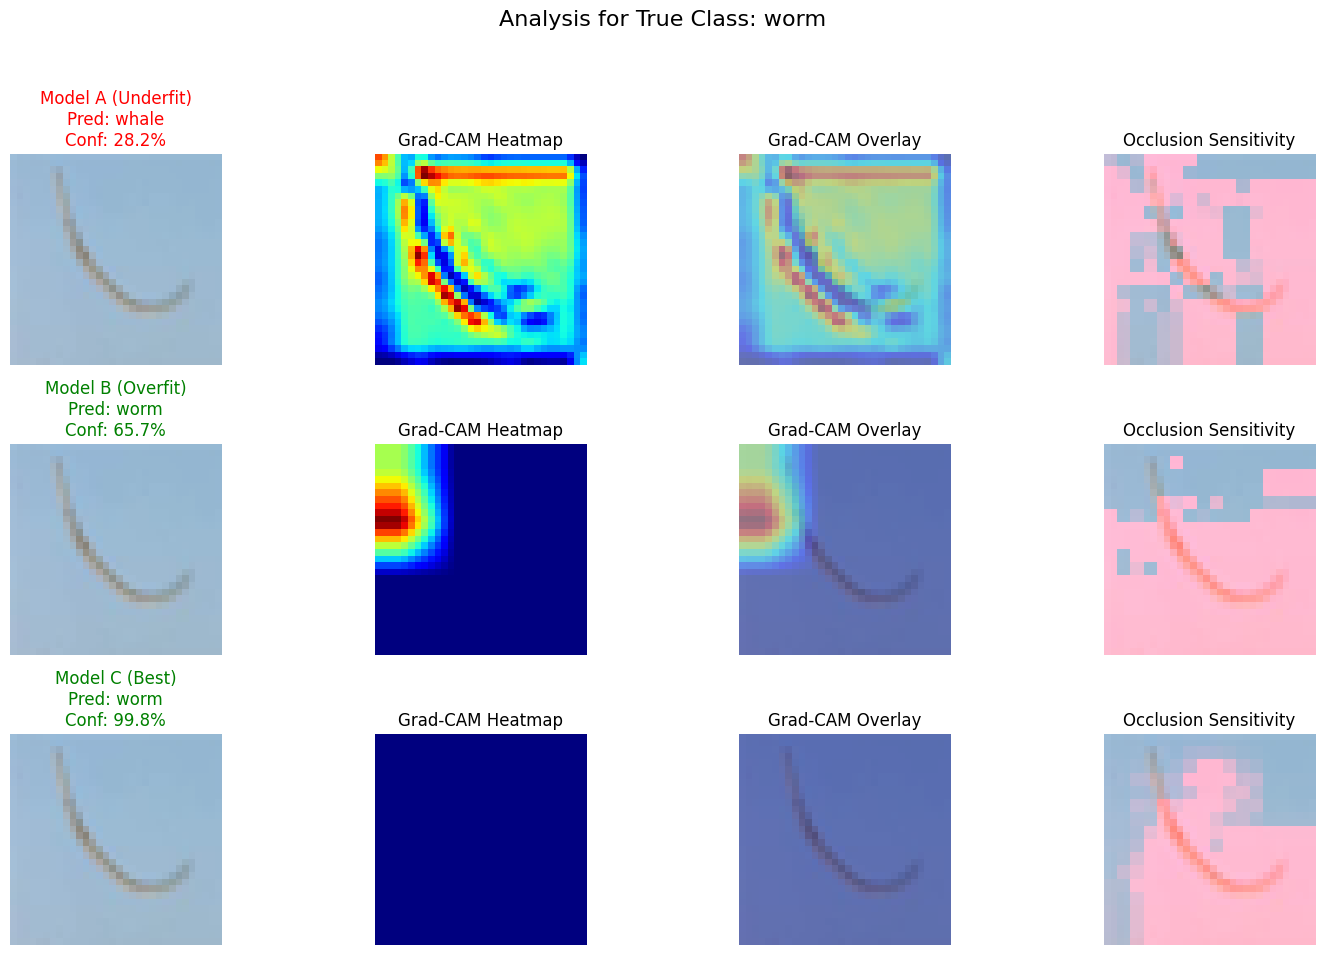

In [5]:
# Visualization Configuration
def show_results():
    # Helper to convert tensor back to image
    def tensor_to_img(t):
        t = t.cpu().clone().detach().numpy().squeeze().transpose(1, 2, 0)
        t = t * std_stats + mean_stats # Un-normalize
        return np.clip(t, 0, 1)

    # Find a suitable sample
    # Looking for a case where Model C is correct, but A or B failed
    target_sample = None
    target_label = None

    print("Searching for an interesting test sample...")
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        out_a = net_a(imgs).argmax(1)
        out_b = net_b(imgs).argmax(1)
        out_c = net_c(imgs).argmax(1)

        # Mask: C is correct AND (A is wrong OR B is wrong)
        mask = (out_c == lbls) & ((out_a != lbls) | (out_b != lbls))

        if mask.any():
            idx = torch.where(mask)[0][0]
            target_sample = imgs[idx:idx+1]
            target_label = lbls[idx].item()
            print(f"Sample found! Class Index: {target_label}")
            break

    if target_sample is None:
        print("No suitable sample found in this batch. Try running again.")
        return

    # Generate Maps
    models_dict = {'Model A (Underfit)': net_a, 'Model B (Overfit)': net_b, 'Model C (Best)': net_c}
    classes = test_data.classes
    true_classname = classes[target_label]

    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Analysis for True Class: {true_classname}", fontsize=16)

    original_img = tensor_to_img(target_sample)

    row = 0
    for name, model in models_dict.items():
        # Get Prediction
        logits = model(target_sample)
        pred_idx = logits.argmax(1).item()
        pred_name = classes[pred_idx]
        confidence = torch.softmax(logits, dim=1)[0, pred_idx].item() * 100

        # 1. Grad-CAM
        cam, _ = compute_gradcam(model, target_sample, target_class=target_label)
        heatmap_cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap_cam = cv2.cvtColor(heatmap_cam, cv2.COLOR_BGR2RGB)
        overlay_cam = 0.4 * heatmap_cam / 255.0 + 0.6 * original_img

        # 2. Occlusion Sensitivity
        occ = compute_occlusion_sensitivity(model, target_sample, target_class=target_label)
        # Resize occlusion map to image size for visualization
        occ_resized = cv2.resize(occ, (original_img.shape[1], original_img.shape[0]))
        # Overlay simply by tinting red
        overlay_occ = original_img.copy()
        overlay_occ[:, :, 0] += occ_resized # Add to red channel

        # Plotting
        # Original Image & Prediction
        ax1 = plt.subplot(3, 4, row * 4 + 1)
        ax1.imshow(original_img)
        color = 'green' if pred_idx == target_label else 'red'
        ax1.set_title(f"{name}\nPred: {pred_name}\nConf: {confidence:.1f}%", color=color)
        ax1.axis('off')

        # Grad-CAM Heatmap
        ax2 = plt.subplot(3, 4, row * 4 + 2)
        ax2.imshow(cam, cmap='jet')
        ax2.set_title("Grad-CAM Heatmap")
        ax2.axis('off')

        # Grad-CAM Overlay
        ax3 = plt.subplot(3, 4, row * 4 + 3)
        ax3.imshow(np.clip(overlay_cam, 0, 1))
        ax3.set_title("Grad-CAM Overlay")
        ax3.axis('off')

        # Occlusion Sensitivity
        ax4 = plt.subplot(3, 4, row * 4 + 4)
        ax4.imshow(np.clip(overlay_occ, 0, 1))
        ax4.set_title("Occlusion Sensitivity")
        ax4.axis('off')

        row += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the visualization
show_results()

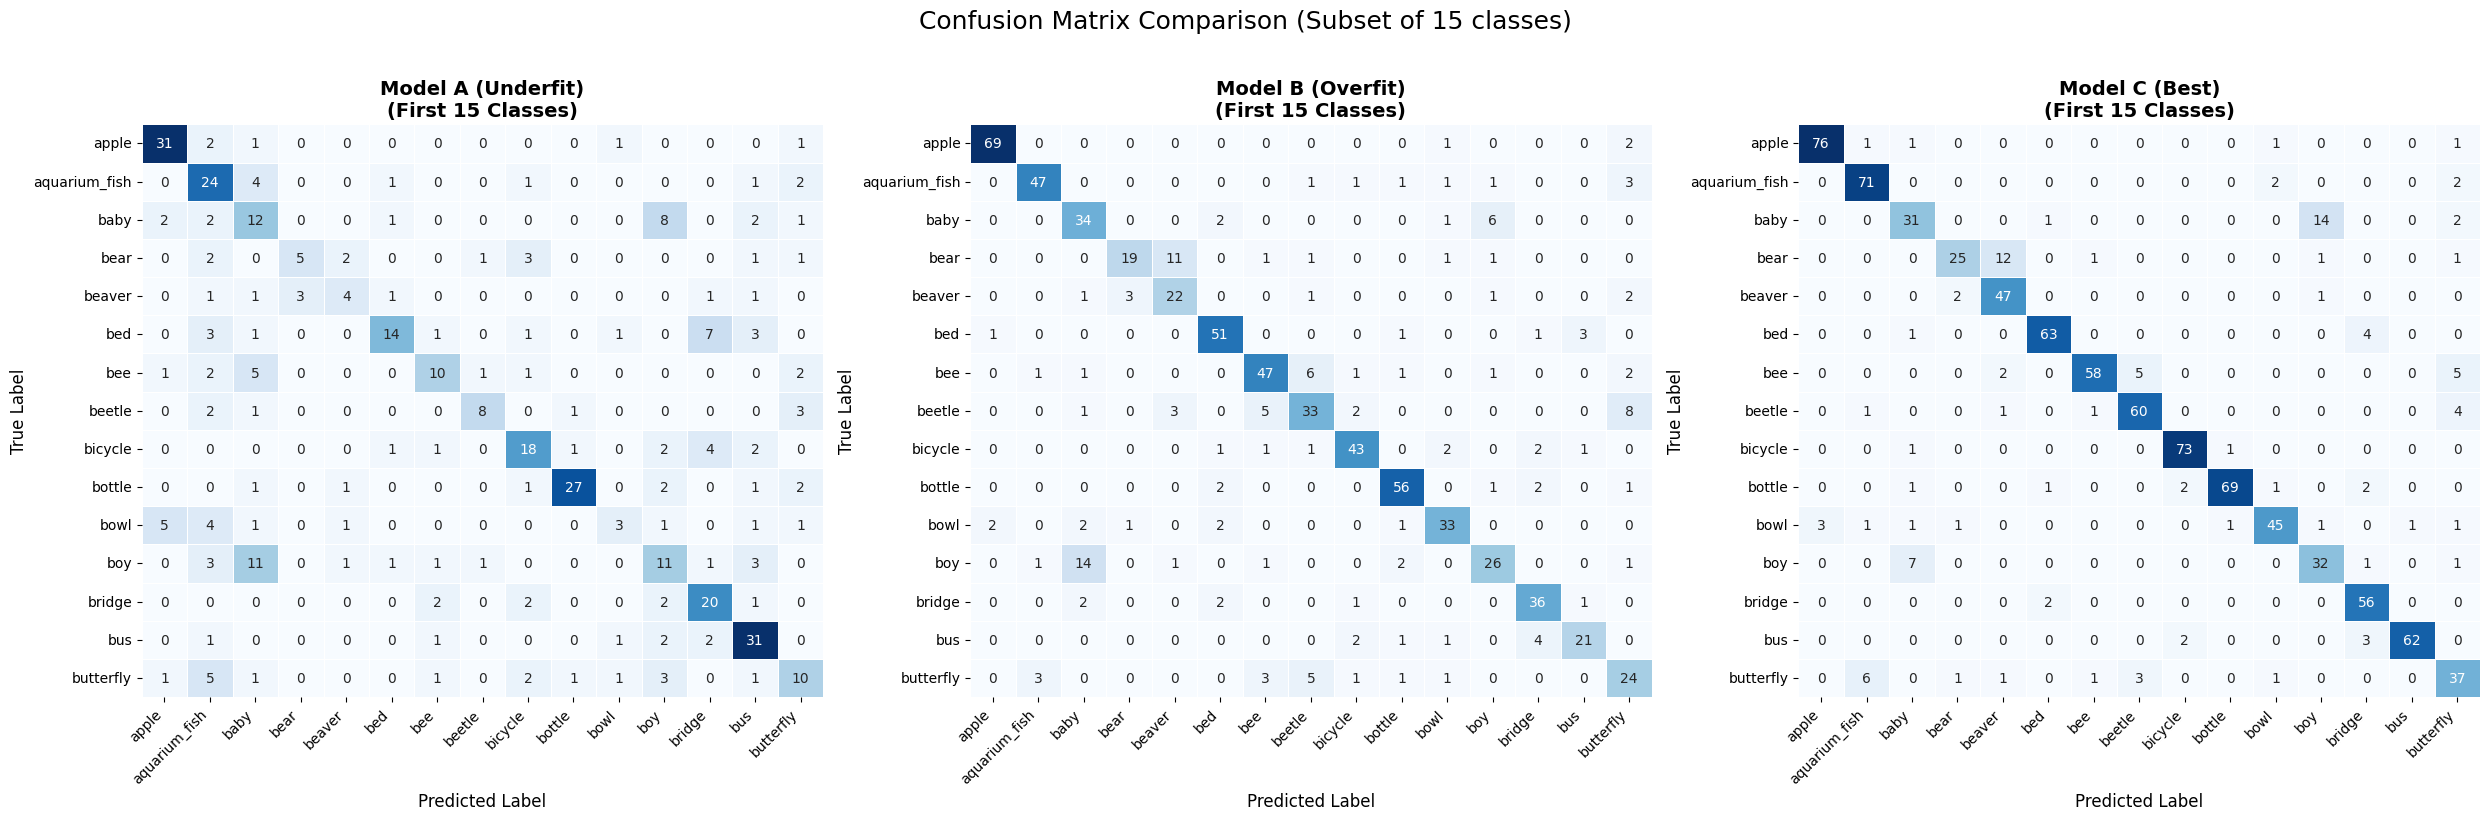

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

def plot_readable_confusion_matrix(models_dict, dataloader, device, num_classes=15):
    """
    Plots a readable Confusion Matrix for the first 'num_classes' classes.
    This allows us to see annotations and labels clearly.
    """
    y_true = []
    y_preds = {name: [] for name in models_dict.keys()}

    print("Collecting predictions for Confusion Matrix...")

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_true.extend(labels.cpu().numpy())

            for name, model in models_dict.items():
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                y_preds[name].extend(predicted.cpu().numpy())

    # Get class names for the subset
    class_names = test_data.classes[:num_classes]

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(25, 8))

    for idx, (name, preds) in enumerate(y_preds.items()):
        # Filter data to only include the first 'num_classes'
        # We create a DataFrame to easily filter logic
        df = pd.DataFrame({'True': y_true, 'Pred': preds})

        # Keep only rows where True label is within our target range
        df_filtered = df[df['True'] < num_classes]

        # Calculate CM only for these classes
        # Note: We must ensure labels parameter covers the range to keep matrix shape fixed
        cm = confusion_matrix(df_filtered['True'], df_filtered['Pred'], labels=list(range(num_classes)))

        ax = axes[idx]

        # Plot Heatmap with Annotations (Numbers)
        sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_names, yticklabels=class_names, linewidths=0.5)

        ax.set_title(f"{name}\n(First {num_classes} Classes)", fontsize=14, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)

        # Rotate x-labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.suptitle(f"Confusion Matrix Comparison (Subset of {num_classes} classes)", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

# Define models
models = {
    'Model A (Underfit)': net_a,
    'Model B (Overfit)': net_b,
    'Model C (Best)': net_c
}

# Run with readable settings (showing first 15 classes)
plot_readable_confusion_matrix(models, test_loader, device, num_classes=15)

Searching for 3 interesting samples...
Visualizing Sample 1/3: cup


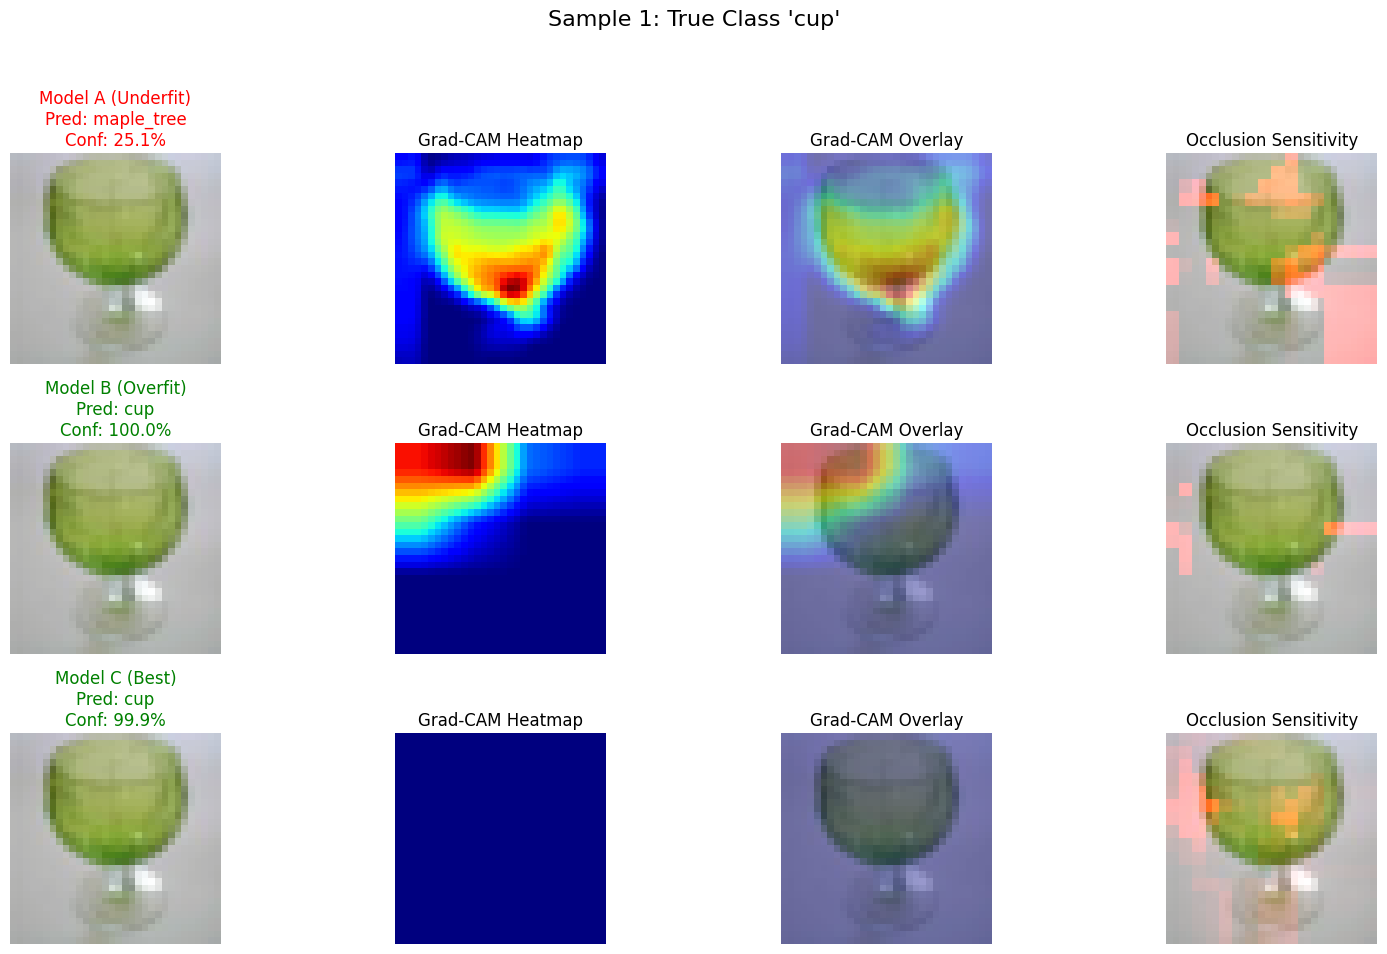

Visualizing Sample 2/3: plate


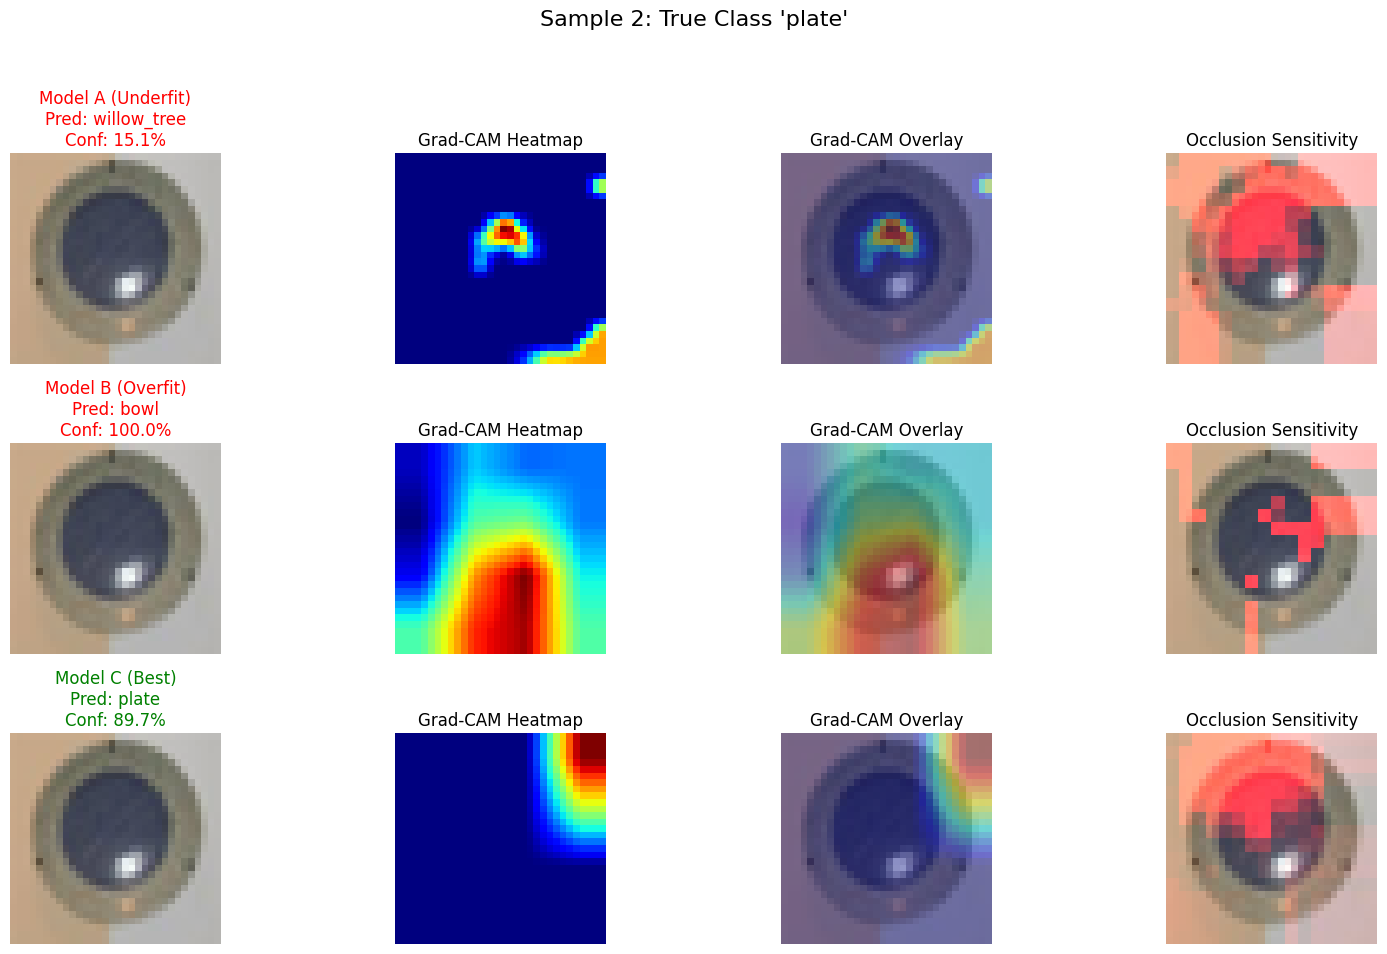

Visualizing Sample 3/3: dinosaur


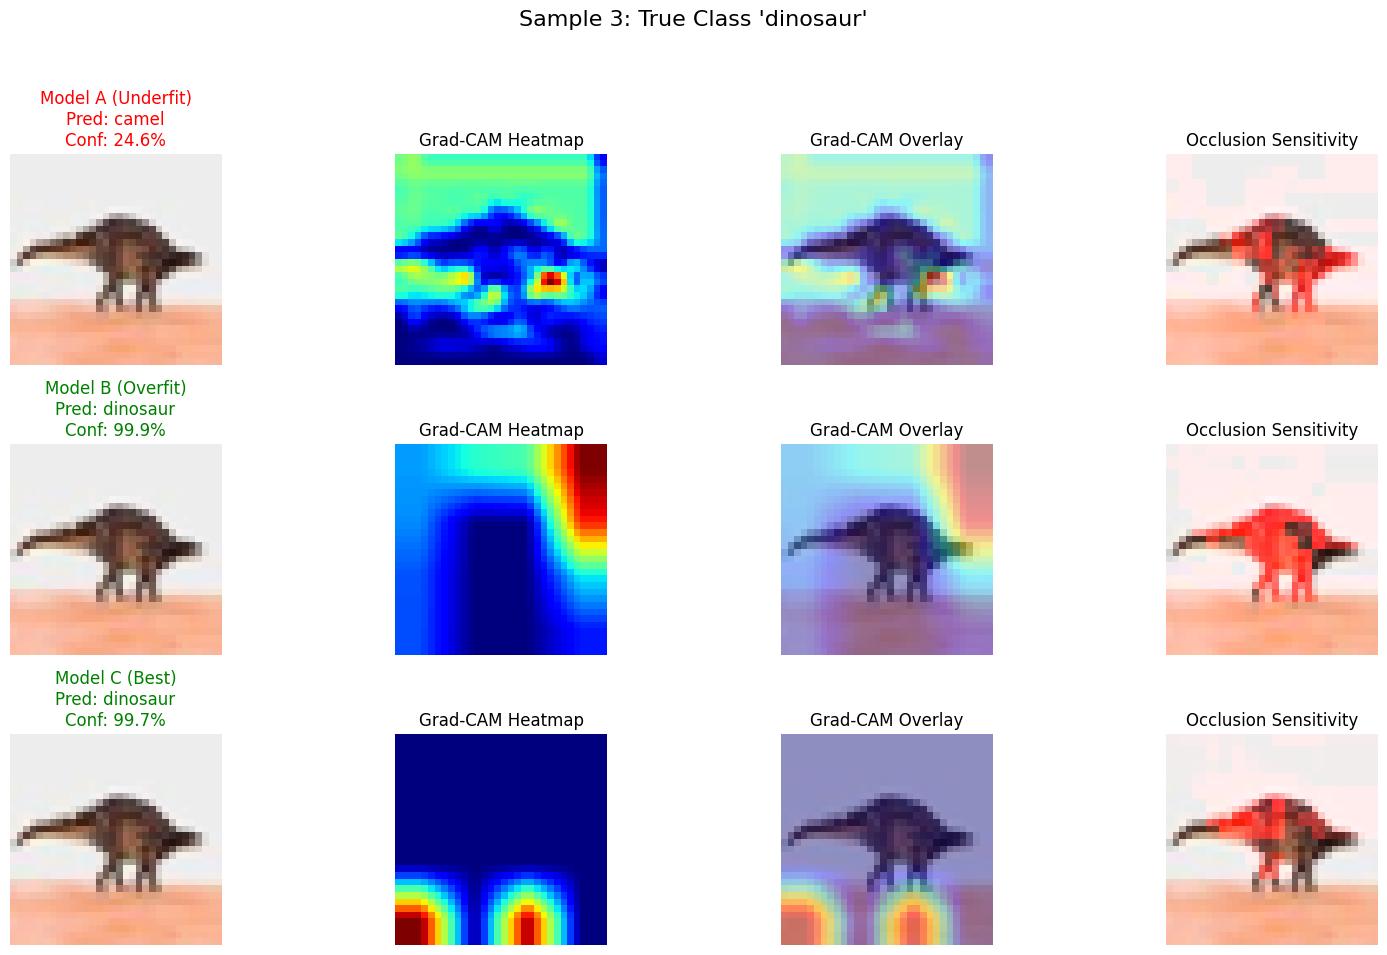

In [7]:
def visualize_multiple_samples(models_dict, dataloader, num_samples=3):
    """
    Finds and visualizes multiple interesting samples where Model C is correct
    but A or B might be wrong.
    """

    # Helper to denormalize image for display
    def tensor_to_img(t):
        t = t.cpu().clone().detach().numpy().squeeze().transpose(1, 2, 0)
        t = t * std_stats + mean_stats
        return np.clip(t, 0, 1)

    found_count = 0

    # Iterator to go through batches
    data_iter = iter(dataloader)

    print(f"Searching for {num_samples} interesting samples...")

    while found_count < num_samples:
        try:
            imgs, lbls = next(data_iter)
        except StopIteration:
            print("End of dataset reached.")
            break

        imgs, lbls = imgs.to(device), lbls.to(device)

        # Get predictions for this batch
        with torch.no_grad():
            out_a = models_dict['Model A (Underfit)'](imgs).argmax(1)
            out_b = models_dict['Model B (Overfit)'](imgs).argmax(1)
            out_c = models_dict['Model C (Best)'](imgs).argmax(1)

        # Criteria: Model C is Correct AND (Model A is Wrong OR Model B is Wrong)
        mask = (out_c == lbls) & ((out_a != lbls) | (out_b != lbls))
        interesting_indices = torch.where(mask)[0]

        for idx in interesting_indices:
            if found_count >= num_samples:
                break

            img_tensor = imgs[idx:idx+1]
            target_label = lbls[idx].item()
            true_classname = test_data.classes[target_label]

            print(f"Visualizing Sample {found_count + 1}/{num_samples}: {true_classname}")

            # Setup Plot for this sample
            fig, axes = plt.subplots(3, 4, figsize=(16, 10))
            fig.suptitle(f"Sample {found_count + 1}: True Class '{true_classname}'", fontsize=16)

            original_img = tensor_to_img(img_tensor)

            row = 0
            for name, model in models_dict.items():
                # Re-run forward pass to get gradients (require_grad context)
                logits = model(img_tensor)
                pred_idx = logits.argmax(1).item()
                confidence = torch.softmax(logits, dim=1)[0, pred_idx].item() * 100
                pred_classname = test_data.classes[pred_idx]

                # 1. Grad-CAM
                cam, _ = compute_gradcam(model, img_tensor, target_class=target_label)
                heatmap_cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
                heatmap_cam = cv2.cvtColor(heatmap_cam, cv2.COLOR_BGR2RGB)
                overlay_cam = 0.4 * heatmap_cam / 255.0 + 0.6 * original_img

                # 2. Occlusion Sensitivity
                occ = compute_occlusion_sensitivity(model, img_tensor, target_class=target_label)
                occ_resized = cv2.resize(occ, (original_img.shape[1], original_img.shape[0]))
                overlay_occ = original_img.copy()
                overlay_occ[:, :, 0] += occ_resized

                # Plot Original & Stats
                color = 'green' if pred_idx == target_label else 'red'
                axes[row, 0].imshow(original_img)
                axes[row, 0].set_title(f"{name}\nPred: {pred_classname}\nConf: {confidence:.1f}%", color=color)
                axes[row, 0].axis('off')

                # Plot Heatmap
                axes[row, 1].imshow(cam, cmap='jet')
                axes[row, 1].set_title("Grad-CAM Heatmap")
                axes[row, 1].axis('off')

                # Plot Overlay
                axes[row, 2].imshow(np.clip(overlay_cam, 0, 1))
                axes[row, 2].set_title("Grad-CAM Overlay")
                axes[row, 2].axis('off')

                # Plot Occlusion
                axes[row, 3].imshow(np.clip(overlay_occ, 0, 1))
                axes[row, 3].set_title("Occlusion Sensitivity")
                axes[row, 3].axis('off')

                row += 1

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

            found_count += 1

# Run for 3 different samples
visualize_multiple_samples(models, test_loader, num_samples=3)